# TD2: Deep learning

In this TD, you must modify this notebook to answer the questions. To do this,

1. Fork this repository
2. Clone your forked repository on your local computer
3. Answer the questions
4. Commit and push regularly

The last commit is due on Sunday, December 1, 11:59 PM. Later commits will not be taken into account.

Install and test PyTorch from  https://pytorch.org/get-started/locally.

In [ ]:
%pip install torch torchvision


To test run the following code

In [2]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import torch.quantization
import json
from PIL import Image
import copy
import time
from torch.optim import lr_scheduler

N, D = 14, 10
x = torch.randn(N, D).type(torch.FloatTensor)
print(x)

from torchvision import models

alexnet = models.alexnet()
print(alexnet)

tensor([[-1.0448,  1.3495, -0.4073, -0.0601,  2.2316, -0.0556, -0.2806,  0.0239,
          1.0922, -2.3037],
        [ 2.3668,  0.8428,  0.8087, -0.6397, -0.5295, -0.5003,  0.4682,  1.2924,
         -0.9323,  1.5477],
        [ 0.6414, -0.0156, -2.9382,  1.3994, -1.0829,  0.7118, -0.2166,  2.0800,
         -1.7264,  1.4773],
        [ 0.3116, -0.6278,  0.2307,  0.1855,  0.2212,  1.1517, -0.7703,  0.2716,
         -0.0741, -0.9202],
        [ 0.9318, -1.3372, -0.1808, -0.6472,  0.8863, -0.6137, -0.3358,  0.8464,
          0.4691, -0.5010],
        [-2.0975, -1.5045, -0.8705, -0.0784, -0.3256, -1.2220,  0.0242, -0.0983,
         -0.1793, -0.1118],
        [ 1.3658,  0.9157,  0.5391, -0.3203, -0.4633,  0.5243,  2.1155, -1.4273,
         -2.0246,  0.8297],
        [ 1.1095,  2.1074,  1.0350, -0.3642, -0.2564,  1.0509, -0.6252, -0.8104,
         -0.0073,  0.1813],
        [-1.0443, -0.6137, -0.2780,  0.0810, -0.1280, -0.3410, -0.1668,  0.7191,
         -0.3391,  0.7248],
        [-1.1858, -

## Exercise 1: CNN on CIFAR10

The goal is to apply a Convolutional Neural Net (CNN) model on the CIFAR10 image dataset and test the accuracy of the model on the basis of image classification. Compare the Accuracy VS the neural network implemented during TD1.

Have a look at the following documentation to be familiar with PyTorch.

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

You can test if GPU is available on your machine and thus train on it to speed up the process

In [6]:


# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print("CUDA is available!  Training on GPU ...")

CUDA is not available.  Training on CPU ...


Next we load the CIFAR10 dataset

In [7]:


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# choose the training and test datasets
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)

# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Files already downloaded and verified
Files already downloaded and verified


CNN definition (this one is an example)

In [8]:


# define the CNN architecture


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# create a complete CNN
model_1 = Net()
print(model_1)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model_1.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Loss function and training using SGD (Stochastic Gradient Descent) optimizer

In [7]:


criterion = nn.CrossEntropyLoss()  # specify loss function
optimizer = optim.SGD(model_1.parameters(), lr=0.01)  # specify optimizer

n_epochs = 30  # number of epochs to train the model
train_loss_list = []  # list to store loss to visualize
valid_loss_list = []
valid_loss_min = np.Inf  # track change in validation loss

for epoch in range(n_epochs):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model_1.train()
    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model_1(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)

    # Validate the model
    model_1.eval()
    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model_1(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss
        valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # Print training/validation statistics
    print(
        "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
            epoch, train_loss, valid_loss
        )
    )

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                valid_loss_min, valid_loss
            )
        )
        torch.save(model_1.state_dict(), "model_1_cifar.pt")
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 42.706410 	Validation Loss: 37.549365
Validation loss decreased (inf --> 37.549365).  Saving model ...
Epoch: 1 	Training Loss: 34.682203 	Validation Loss: 32.756616
Validation loss decreased (37.549365 --> 32.756616).  Saving model ...
Epoch: 2 	Training Loss: 30.741905 	Validation Loss: 29.590071
Validation loss decreased (32.756616 --> 29.590071).  Saving model ...
Epoch: 3 	Training Loss: 28.491642 	Validation Loss: 27.348559
Validation loss decreased (29.590071 --> 27.348559).  Saving model ...
Epoch: 4 	Training Loss: 26.764905 	Validation Loss: 25.580812
Validation loss decreased (27.348559 --> 25.580812).  Saving model ...
Epoch: 5 	Training Loss: 25.264787 	Validation Loss: 24.726740
Validation loss decreased (25.580812 --> 24.726740).  Saving model ...
Epoch: 6 	Training Loss: 23.990562 	Validation Loss: 24.224369
Validation loss decreased (24.726740 --> 24.224369).  Saving model ...
Epoch: 7 	Training Loss: 22.904920 	Validation Loss: 23.848258
Valid

Does overfit occur? If so, do an early stopping.

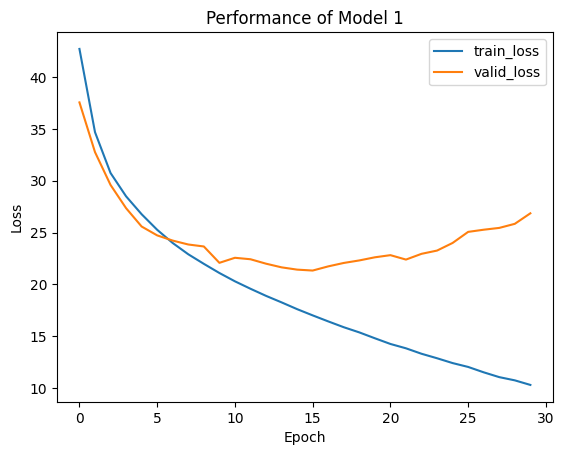

In [8]:


fig_1,ax_1 = plt.subplots()
ax_1.plot(range(n_epochs), train_loss_list, label = 'train_loss')
ax_1.legend()
ax_1.plot(range(n_epochs), valid_loss_list, label = 'valid_loss')
ax_1.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()

Now loading the model with the lowest validation loss value

In [26]:
 model_1.load_state_dict(torch.load("./model_1_cifar.pt"))

# track test loss
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
accuracy_per_class_m1 =  list(0.0 for i in range(10))
model_1.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_1(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        accuracy_per_class_m1 = 100 * class_correct[i] / class_total[i]
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                accuracy_per_class_m1,
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )
        
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy of model 1 (Overall): %2f%% (%2f/%2f)"
    % (
        100.0 * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct),
        np.sum(class_total),
    )
)

Test Loss: 21.184199

Test Accuracy of airplane: 65% (651/1000)
Test Accuracy of automobile: 75% (754/1000)
Test Accuracy of  bird: 55% (552/1000)
Test Accuracy of   cat: 39% (394/1000)
Test Accuracy of  deer: 56% (568/1000)
Test Accuracy of   dog: 56% (562/1000)
Test Accuracy of  frog: 69% (695/1000)
Test Accuracy of horse: 66% (661/1000)
Test Accuracy of  ship: 80% (805/1000)
Test Accuracy of truck: 71% (718/1000)

Test Accuracy of model 1 (Overall): 63.600000% (6360.000000/10000.000000)


Second Network :

In [10]:


# define the CNN architecture


class Second_Net(nn.Module):
    def __init__(self):
        super(Second_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # H_out(conv1) = W_out(conv1) = (H_in + 2*padding - Kernel)/stride + 1 = (32 + 2 - 3)/1 + 1 = 32
        # Size(conv1_out) = 32*32*16
        self.pool = nn.MaxPool2d(2, 2)  # After Maxpooling2D new size of image equal =  16*16
        # H_out(conv2) = W_out(conv2) = (H_in + 2*padding - Kernel)/stride + 1 = (16 + 2 - 3)/1 + 1 = 16
                                        # After Maxpooling2D new size of image equal =  8*8
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # H_out(conv3) = W_out(conv3) = (H_in + 2*padding - Kernel)/stride + 1 = (16 + 2 - 3)/1 + 1 = 8
                                        # After Maxpooling2D new size of image equal =  4*4
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  
        self.fc1 = nn.Linear(64 * 4 * 4, 512)   
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# create a complete CNN
model_2 = Second_Net()
print(model_2)
# move tensors to GPU if CUDA is available
# if train_on_gpu:
  #  model.cuda()

Second_Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


 Training the new model

In [11]:

criterion = nn.CrossEntropyLoss()  # specify loss function
optimizer = optim.SGD(model_2.parameters(), lr=0.01)  # specify optimizer
train_loss_list_2 = []  # list to store loss to visualize
valid_loss_list_2 = []
valid_loss_min = np.Inf  # track change in validation loss

for epoch in range(n_epochs):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model_2.train()
    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model_2(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)

    # Validate the model
    model_2.eval()
    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model_2(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss
        valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_loss_list_2.append(train_loss)
    valid_loss_list_2.append(valid_loss)

    # Print training/validation statistics
    print(
        "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
            epoch, train_loss, valid_loss
        )
    )

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                valid_loss_min, valid_loss
            )
        )
        torch.save(model_2.state_dict(), "model_2_cifar.pt")
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 45.198202 	Validation Loss: 40.966207
Validation loss decreased (inf --> 40.966207).  Saving model ...
Epoch: 1 	Training Loss: 37.330688 	Validation Loss: 33.521531
Validation loss decreased (40.966207 --> 33.521531).  Saving model ...
Epoch: 2 	Training Loss: 31.562392 	Validation Loss: 29.229370
Validation loss decreased (33.521531 --> 29.229370).  Saving model ...
Epoch: 3 	Training Loss: 28.058459 	Validation Loss: 26.177679
Validation loss decreased (29.229370 --> 26.177679).  Saving model ...
Epoch: 4 	Training Loss: 25.456967 	Validation Loss: 23.716301
Validation loss decreased (26.177679 --> 23.716301).  Saving model ...
Epoch: 5 	Training Loss: 23.113733 	Validation Loss: 22.240193
Validation loss decreased (23.716301 --> 22.240193).  Saving model ...
Epoch: 6 	Training Loss: 21.204408 	Validation Loss: 20.603154
Validation loss decreased (22.240193 --> 20.603154).  Saving model ...
Epoch: 7 	Training Loss: 19.409736 	Validation Loss: 19.268198
Valid

Plot Loss in function epoch for the new model

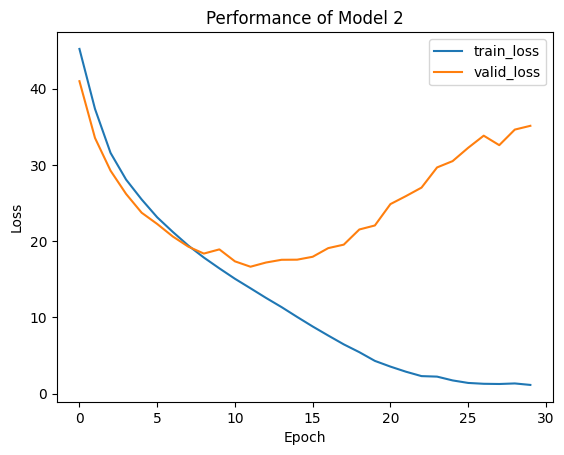

In [12]:


fig_2,ax_2 = plt.subplots()
ax_2.plot(range(n_epochs), train_loss_list_2, label = 'train_loss')
ax_2.legend()
ax_2.plot(range(n_epochs), valid_loss_list_2, label = 'valid_loss')
ax_2.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 2")
plt.show()

Loading the second model with the lowest validation loss value

In [27]:
model_2.load_state_dict(torch.load("./model_2_cifar.pt"))

class_correct2 = list(0.0 for i in range(10))
class_total2 = list(0.0 for i in range(10))
accuracy_per_class_m2 = list(0.0 for i in range(10))
model_2.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_2(data)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct2 = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct2[label] += correct2[i].item()
        class_total2[label] += 1


for i in range(10):
    if class_total2[i] > 0:
        accuracy_per_class_m2 =  100 * class_correct2[i] / class_total2[i]
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                accuracy_per_class_m2,
                np.sum(class_correct2[i]),
                np.sum(class_total2[i]),
            )
        )
       
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy (Overall): %2f%% (%2f/%2f)"
    % (
        100.0 * np.sum(class_correct2) / np.sum(class_total2),
        np.sum(class_correct2),
        np.sum(class_total2),
    )
)



Test Accuracy of airplane: 74% (743/1000)
Test Accuracy of automobile: 83% (839/1000)
Test Accuracy of  bird: 62% (624/1000)
Test Accuracy of   cat: 45% (453/1000)
Test Accuracy of  deer: 58% (586/1000)
Test Accuracy of   dog: 70% (704/1000)
Test Accuracy of  frog: 76% (768/1000)
Test Accuracy of horse: 71% (719/1000)
Test Accuracy of  ship: 79% (798/1000)
Test Accuracy of truck: 79% (795/1000)

Test Accuracy (Overall): 70.290000% (7029.000000/10000.000000)


With this new network our accuracy increased up to 70.290%

Build a new network with the following structure.

- It has 3 convolutional layers of kernel size 3 and padding of 1.
- The first convolutional layer must output 16 channels, the second 32 and the third 64.
- At each convolutional layer output, we apply a ReLU activation then a MaxPool with kernel size of 2.
- Then, three fully connected layers, the first two being followed by a ReLU activation and a dropout whose value you will suggest.
- The first fully connected layer will have an output size of 512.
- The second fully connected layer will have an output size of 64.

Compare the results obtained with this new network to those obtained previously.

 ## Exercise 2: Quantization: try to compress the CNN to save space
 
 Quantization doc is available from https://pytorch.org/docs/stable/quantization.html#torch.quantization.quantize_dynamicThe Exercise is to quantize post training the above CNN model. Compare the size reduction and the impact on the classification accuracy The size of the model is simply the size of the file.

In [9]:



def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    print("model: ", label, " \t", "Size (KB):", size / 1e3)
    os.remove("temp.p")
    return size


print_size_of_model(model_1, "fp32")

model:  fp32  	 Size (KB): 251.278


251278

The size of model 1 before Post training quantization is 251.278KB

 **Post training quantization of model 1**

In [15]:


quantized_model_1 = torch.quantization.quantize_dynamic(model_1, dtype=torch.qint8)
print_size_of_model(quantized_model_1, "int8")

model:  int8  	 Size (KB): 76.522


76522

The size of model 1 after Post training quantization is 76.522 KB, so The size of Model 1 was reduced by 174,748 KB after post training quantization

**Post otraining quantization of model 2**

In [16]:
print_size_of_model(model_2, "fp32")
quantized_model_2 = torch.quantization.quantize_dynamic(model_2, dtype=torch.qint8)
print_size_of_model(quantized_model_2, "int8")


model:  fp32  	 Size (KB): 2330.946
model:  int8  	 Size (KB): 659.806


659806

The size of Model 2 was reduced by 1671.14 KB after post training quantization

**Classification test of quantized model 1**

In [25]:
# quantized_model_1.load_state_dict(torch.load("./quantizedmodel_cifar.pt"))



class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
accuracy_per_class_q1 = list(0.0 for i in range(10))
quantized_model_1.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = quantized_model_1(data)
   
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )
        accuracy_per_class_q1[i] = (class_correct[i]/class_total[i])*100
    else:
        print("Test Accuracy of quantized model 1 %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy of quantized model 1 (Overall): %2f%% (%2f/%2f)"
    % (
        100.0 * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct),
        np.sum(class_total),
    )
)

Test Accuracy of airplane: 64% (647/1000)
Test Accuracy of automobile: 75% (755/1000)
Test Accuracy of  bird: 55% (551/1000)
Test Accuracy of   cat: 38% (384/1000)
Test Accuracy of  deer: 58% (581/1000)
Test Accuracy of   dog: 55% (558/1000)
Test Accuracy of  frog: 69% (696/1000)
Test Accuracy of horse: 66% (662/1000)
Test Accuracy of  ship: 80% (806/1000)
Test Accuracy of truck: 72% (721/1000)

Test Accuracy of quantized model 1 (Overall): 63.610000% (6361.000000/10000.000000)


**Classification test of quantized model 2**

In [28]:
#  quantized_model_2.load_state_dict(torch.load("./model_cifar.pt"))



class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
accuracy_per_class_q2 = list(0.0 for i in range(10))
quantized_model_2.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = quantized_model_2(data)
   
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )
        accuracy_per_class_q2[i] = (class_correct[i]/class_total[i])*100
    else:
        print("Test Accuracy of quantized model 2 %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy of quantized model 2 (Overall): %2f%% (%2f/%2f)"
    % (
        100.0 * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct),
        np.sum(class_total),
    )
)

Test Accuracy of airplane: 74% (746/1000)
Test Accuracy of automobile: 83% (839/1000)
Test Accuracy of  bird: 61% (617/1000)
Test Accuracy of   cat: 45% (455/1000)
Test Accuracy of  deer: 58% (588/1000)
Test Accuracy of   dog: 70% (704/1000)
Test Accuracy of  frog: 76% (768/1000)
Test Accuracy of horse: 72% (720/1000)
Test Accuracy of  ship: 79% (791/1000)
Test Accuracy of truck: 79% (791/1000)

Test Accuracy of quantized model 2 (Overall): 70.190000% (7019.000000/10000.000000)


**Comparison accuracy result between model 1 and quantized model 1**

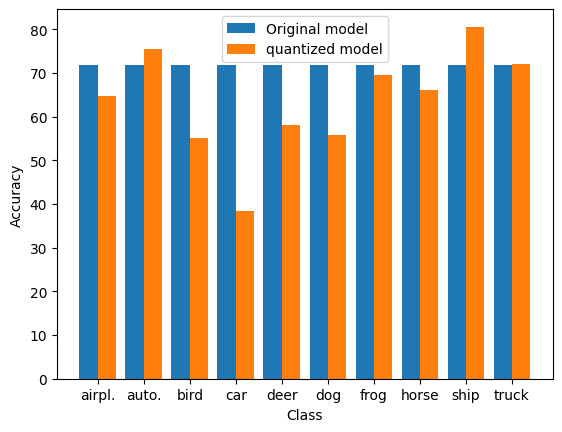

In [32]:
fig_4, ax_4 = plt.subplots()
w = 0.4
x = ["airpl.", "auto.", "bird", "car", "deer", "dog", "frog", "horse", "ship", "truck"]
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
ax_4.bar(bar1,accuracy_per_class_m1,w,label="Original model")
ax_4.bar(bar2,accuracy_per_class_q1,w,label="quantized model")
ax_4.set_xticks(bar1+w/2,x)
ax_4.legend()
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()

**Comparison accuracy result between model 2 and quantized model 2**

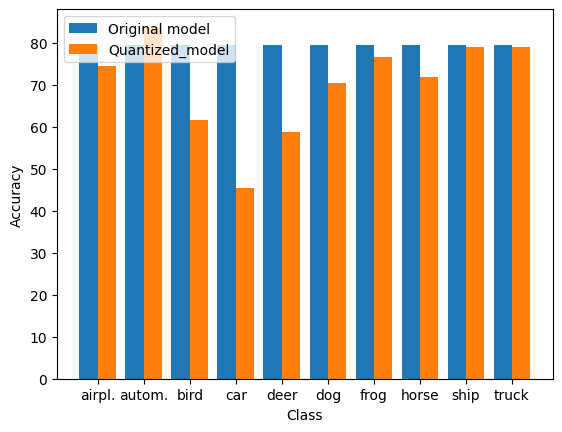

In [36]:
fig_5, ax_5 = plt.subplots()
w = 0.4
x = ["airpl.", "autom.", "bird", "car", "deer", "dog", "frog", "horse", "ship", "truck"]
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
ax_5.bar(bar1,accuracy_per_class_m2,w,label="Original model")
ax_5.bar(bar2,accuracy_per_class_q2,w,label="Quantized_model")
ax_5.set_xticks(bar1+w/2,x)
ax_5.legend()
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()

 ## Exercise 3: working with pre-trained models.

PyTorch offers several pre-trained models https://pytorch.org/vision/0.8/models.htmlWe will use ResNet50 trained on ImageNet dataset (https://www.image-net.org/index.php). Use the following code with the files imagenet-simple-labels.json that contains the imagenet labels and the image dog.png that we will use as test.

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

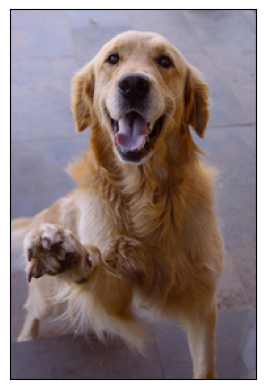

In [3]:


# Choose an image to pass through the model
test_image = "dog.PNG"

# Configure matplotlib for pretty inline plots
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

# Prepare the labels
with open("imagenet-simple-labels.json") as f:
    labels = json.load(f)

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
# Load the image

image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
# image = data_transform(image).unsqueeze(0).cuda()
image = data_transform(image).unsqueeze(0)

# Download the model if it's not there already. It will take a bit on the first run, after that it's fast
model_3 = models.resnet50(pretrained=True)  #  pretrained=True : permet d'obtenir les valeurs des poids après le pré-entrainement.
print(model_3)
# Send the model to the GPU
# model.cuda()
# Set layers such as dropout and batchnorm in evaluation mode
model_3.eval()

# Get the 1000-dimensional model output
out = model_3(image)
# Find the predicted class
print("Predicted class is: {}".format(labels[out.argmax()]))

**Size of resnet50 model :**

In [22]:
print_size_of_model(model_3, "fp32")

model:  fp32  	 Size (KB): 102523.238


102523238

**Post training quantization of resnet50 model :** 

In [23]:
quantized_model_3 = torch.quantization.quantize_dynamic(model_3, dtype=torch.qint8)
print_size_of_model(quantized_model_3, "int8")

model:  int8  	 Size (KB): 96379.996


96379996

**Test classification of quantized resnet50 model :** 

model:  int8  	 Size (KB): 96379.996
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64,

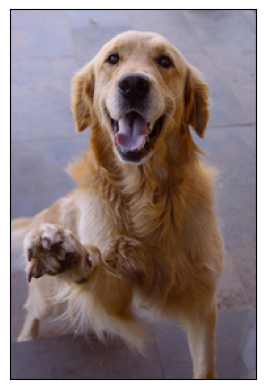

In [10]:
import json
from PIL import Image

# Choose an image to pass through the model
test_image = "dog.PNG"

# Configure matplotlib for pretty inline plots
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

# Prepare the labels
with open("imagenet-simple-labels.json") as f:
    labels = json.load(f)

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
# Load the image

image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
# image = data_transform(image).unsqueeze(0).cuda()
image = data_transform(image).unsqueeze(0)

# Download the model if it's not there already. It will take a bit on the first run, after that it's fast
model_3 = models.resnet50(pretrained=True)  #  pretrained=True : allows you to obtain the weight values after the pre-training.
quantized_model_3 = torch.quantization.quantize_dynamic(model_3, dtype=torch.qint8)
print_size_of_model(quantized_model_3, "int8")
print(quantized_model_3)
# Send the model to the GPU
# model.cuda()
# Set layers such as dropout and batchnorm in evaluation mode
quantized_model_3.eval()

# Get the 1000-dimensional model output
out = quantized_model_3(image)
# Find the predicted class
print("Predicted class is: {}".format(labels[out.argmax()]))

**Now we will test our model resnet50 with other images:**

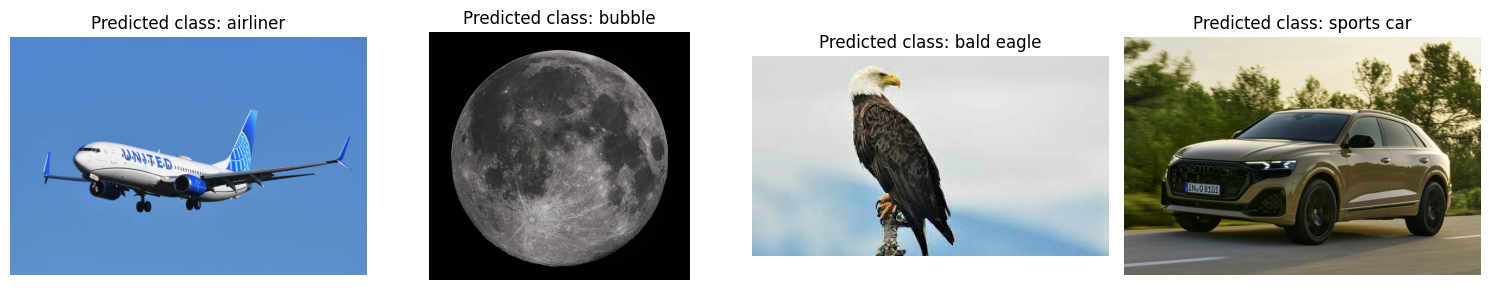

In [17]:
import json
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models

# List of test images:
image_list = ["Plane.jpg", "Moon.jpg", "eagle.jpeg", "Audi_Q8.jpg"]

# Prepare the labels
with open("imagenet-simple-labels.json") as f:
    labels = json.load(f)

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load model
model_3 = models.resnet50(pretrained=True)
model_3.eval()

# Set up subplots
fig, axes = plt.subplots(1, len(image_list), figsize=(15, 3))

# Loop through the image list
for i, image_path in enumerate(image_list):
    # Load image
    image = Image.open(image_path)
    
    # Apply transformations
    image_tensor = data_transform(image).unsqueeze(0)
    
    # Perform inference with the model
    with torch.no_grad():
        out = model_3(image_tensor)
    
    # Display the image with its predicted class
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted class: {labels[out.argmax()]}")
    axes[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()    

 Experiments:Study the code and the results obtained. Possibly add other images downloaded from the internet.What is the size of the model? Quantize it and then check if the model is still able to correctly classify the other images.Experiment with other pre-trained CNN models.

##  Exercise 4: Transfer Learning

For this work, we will use a pre-trained model (ResNet18) as a descriptor extractor and will refine the classification by training only the last fully connected layer of the network. Thus, the output layer of the pre-trained network will be replaced by a layer adapted to the new classes to be recognized which will be in our case ants and bees.
Download and unzip in your working directory the dataset available at the address :https://download.pytorch.org/tutorial/hymenoptera_data.zipExecute the following code in order to display some images of the dataset.

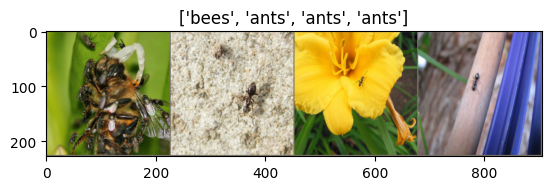

In [9]:


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(
                224
            ),  # ImageNet models were trained on 224x224 images
            transforms.RandomHorizontalFlip(),  # flip horizontally 50% of the time - increases train set variability
            transforms.ToTensor(),  # convert it to a PyTorch tensor
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # ImageNet models expect this norm
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    
    ),
}

data_dir = "hymenoptera_data"
# Create train and validation datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val", "test"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=0
    )
    for x in ["train", "val", "test"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

 Now, execute the following code which uses a pre-trained model ResNet18 having replaced the output layer for the ants/bees classification and performs the model training by only changing the weights of this output layer.

In [20]:
# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])
# training
train_loss_list_7 = []
valid_loss_list_7 = []
train_accuracy_list_7 = []
valid_accuracy_list_7 = []
test_loss_list_7 = []
test_accuracy_list_7 = []

num_epochs = 10

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_time = []  # we'll keep track of the time needed for each epoch
    
    

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
         
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            if phase == "train" :
                train_loss_list_7.append(epoch_loss)
                train_accuracy_list_7.append(epoch_acc)
            elif phase == "val":
                valid_loss_list_7.append(epoch_loss)
                valid_accuracy_list_7.append(epoch_acc
                )

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time


def test_model (model, criterion):
    since = time.time()

    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataloaders["test"] :
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    test_loss = running_loss/dataset_sizes["test"]
    test_accuracy = running_corrects.double()/dataset_sizes["test"]
    test_loss_list_7.append(test_loss)
    test_accuracy_list_7.append(test_accuracy)

    print("test loss is %2f and test accuracy  is %2f" %(test_loss, test_accuracy ))

    return test_loss, test_accuracy
    


# Download a pre-trained ResNet18 model and freeze its weights
model_N1 = torchvision.models.resnet18(pretrained=True)
for param in model_N1.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_N1.fc.in_features
model_N1.fc = nn.Linear(num_ftrs, 2)

# Send the model to the GPU
model_N1 = model_N1.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model_N1.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_N1, epoch_time = train_model(
    model_N1, criterion, optimizer_conv, exp_lr_scheduler, num_epochs )

test_loss, test_accuracy = test_model(model_N1, criterion)


Epoch 1/10
----------
train Loss: 0.5579 Acc: 0.7090
val Loss: 0.2821 Acc: 0.9020

Epoch 2/10
----------
train Loss: 0.4667 Acc: 0.8074
val Loss: 0.2217 Acc: 0.9542

Epoch 3/10
----------
train Loss: 0.4692 Acc: 0.7828
val Loss: 0.1792 Acc: 0.9477

Epoch 4/10
----------
train Loss: 0.4409 Acc: 0.7746
val Loss: 0.1982 Acc: 0.9281

Epoch 5/10
----------
train Loss: 0.4173 Acc: 0.8320
val Loss: 0.2318 Acc: 0.9020

Epoch 6/10
----------
train Loss: 0.3639 Acc: 0.8279
val Loss: 0.1922 Acc: 0.9542

Epoch 7/10
----------
train Loss: 0.3660 Acc: 0.8279
val Loss: 0.1792 Acc: 0.9542

Epoch 8/10
----------
train Loss: 0.3840 Acc: 0.8443
val Loss: 0.1892 Acc: 0.9477

Epoch 9/10
----------
train Loss: 0.3703 Acc: 0.8607
val Loss: 0.1863 Acc: 0.9608

Epoch 10/10
----------
train Loss: 0.3013 Acc: 0.8730
val Loss: 0.1911 Acc: 0.9608

Training complete in 2m 49s
Best val Acc: 0.960784
test loss is 0.122250 and test accuracy  is 0.950000


Performance of resnet18 model

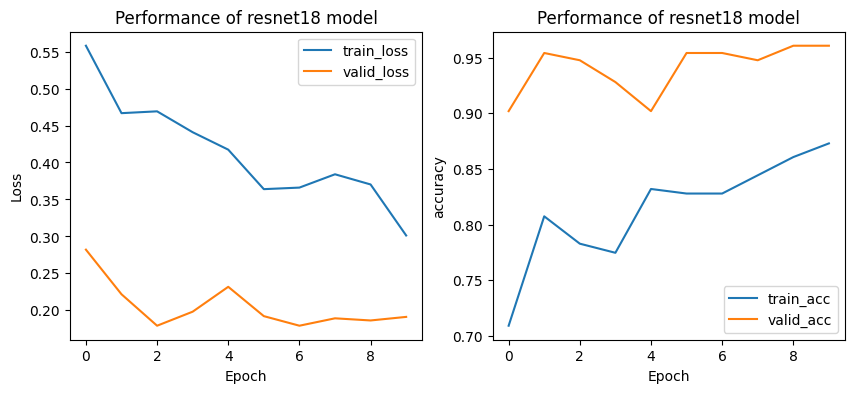

In [21]:


fig_6 = plt.figure() 
fig_6.set_size_inches(10, 4)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
ax_6_1 = plt.subplot(1,2,1) 
ax_6_2 = plt.subplot(1,2,2)
ax_6_1.plot(range(num_epochs), train_loss_list_7, label = 'train_loss')
ax_6_1.legend()
ax_6_1.plot(range(num_epochs), valid_loss_list_7, label = 'valid_loss')
ax_6_1.legend()
ax_6_1.set_xlabel("Epoch")
ax_6_1.set_ylabel("Loss")
ax_6_1.set_title("Performance of resnet18 model")
ax_6_2.plot(range(num_epochs), train_accuracy_list_7, label = 'train_acc')
ax_6_2.legend()
ax_6_2.plot(range(num_epochs), valid_accuracy_list_7, label = 'valid_acc')
ax_6_2.legend()
ax_6_2.set_xlabel("Epoch")
ax_6_2.set_ylabel("accuracy")
ax_6_2.set_title("Performance of resnet18 model")
plt.show()



Now modify the code to replace the current classification layer with a set of two layers using a "relu" activation function for the middle layer, and the "dropout" mechanism for both layers. Renew the experiments and study the results obtained.

**Hidden dim = 256**

In [22]:
train_loss_list_8 = []
valid_loss_list_8 = []
train_accuracy_list_8 = []
valid_accuracy_list_8 = []
test_loss_list_8 = []
test_accuracy_list_8 = []
hidden_dim = 256
num_epochs = 10

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_time = []  # we'll keep track of the time needed for each epoch
    
    

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
         
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            if phase == "train" :
                train_loss_list_8.append(epoch_loss)
                train_accuracy_list_8.append(epoch_acc)
            elif phase == "val":
                valid_loss_list_8.append(epoch_loss)
                valid_accuracy_list_8.append(epoch_acc
                )

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time


def test_model (model, criterion):
    since = time.time()

    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataloaders["test"] :
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    test_loss = running_loss/dataset_sizes["test"]
    test_accuracy = running_corrects.double()/dataset_sizes["test"]
    test_loss_list_8.append(test_loss)
    test_accuracy_list_8.append(test_accuracy)

    print("test loss is %2f and test accuracy  is %2f" %(test_loss, test_accuracy ))

    return test_loss, test_accuracy
    


# Download a pre-trained ResNet18 model and freeze its weights
model_N2 = torchvision.models.resnet18(pretrained=True)
for param in model_N2.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_N2.fc.in_features
model_N2.fc = nn.Sequential(
nn.Dropout(0.2),     
nn.Linear(num_ftrs, hidden_dim),
nn.ReLU(),
nn.Linear(hidden_dim, 2))

# Send the model to the GPU
model_N2 = model_N2.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model_N2.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_N2, epoch_time = train_model(
    model_N2, criterion, optimizer_conv, exp_lr_scheduler, num_epochs )

test_loss, test_accuracy = test_model(model_N2, criterion)

Epoch 1/10
----------
train Loss: 0.6311 Acc: 0.6270
val Loss: 0.4179 Acc: 0.9020

Epoch 2/10
----------
train Loss: 0.5302 Acc: 0.7213
val Loss: 0.3562 Acc: 0.8366

Epoch 3/10
----------
train Loss: 0.4946 Acc: 0.7500
val Loss: 0.2454 Acc: 0.9150

Epoch 4/10
----------
train Loss: 0.3952 Acc: 0.8156
val Loss: 0.1762 Acc: 0.9477

Epoch 5/10
----------
train Loss: 0.5007 Acc: 0.7582
val Loss: 0.1992 Acc: 0.9346

Epoch 6/10
----------
train Loss: 0.3985 Acc: 0.8279
val Loss: 0.1783 Acc: 0.9477

Epoch 7/10
----------
train Loss: 0.4048 Acc: 0.8238
val Loss: 0.1834 Acc: 0.9412

Epoch 8/10
----------
train Loss: 0.3712 Acc: 0.8320
val Loss: 0.1913 Acc: 0.9346

Epoch 9/10
----------
train Loss: 0.4335 Acc: 0.7828
val Loss: 0.1894 Acc: 0.9477

Epoch 10/10
----------
train Loss: 0.3929 Acc: 0.8115
val Loss: 0.1828 Acc: 0.9346

Training complete in 2m 54s
Best val Acc: 0.947712
test loss is 0.101250 and test accuracy  is 1.000000


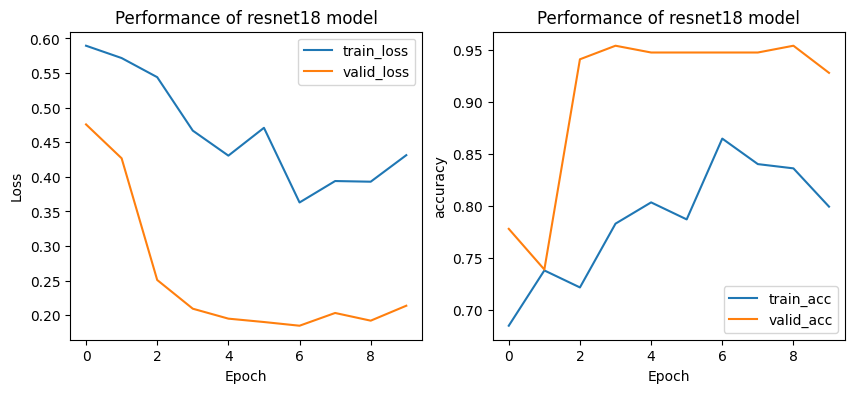

In [15]:
fig_6 = plt.figure() 
fig_6.set_size_inches(10, 4)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
ax_6_1 = plt.subplot(1,2,1) 
ax_6_2 = plt.subplot(1,2,2)
ax_6_1.plot(range(num_epochs), train_loss_list_8, label = 'train_loss')
ax_6_1.legend()
ax_6_1.plot(range(num_epochs), valid_loss_list_8, label = 'valid_loss')
ax_6_1.legend()
ax_6_1.set_xlabel("Epoch")
ax_6_1.set_ylabel("Loss")
# ax_6_1.set_title("Performance of resnet18 model")
ax_6_2.plot(range(num_epochs), train_accuracy_list_8, label = 'train_acc')
ax_6_2.legend()
ax_6_2.plot(range(num_epochs), valid_accuracy_list_8, label = 'valid_acc')
ax_6_2.legend()
ax_6_2.set_xlabel("Epoch")
ax_6_2.set_ylabel("accuracy")
# ax_6_2.set_title("Performance of resnet18 model")
plt.title("Performance of resnet18 model with a classification layer composed of two layers and hidden dim = 256")
plt.show()

**Hidden dim = 1024**

In [23]:
train_loss_list_9 = []
valid_loss_list_9 = []
train_accuracy_list_9 = []
valid_accuracy_list_9 = []
test_loss_list_9 = []
test_accuracy_list_9 = []
hidden_dim = 1024
num_epochs = 10

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_time = []  # we'll keep track of the time needed for each epoch
    
    

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
         
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            if phase == "train" :
                train_loss_list_9.append(epoch_loss)
                train_accuracy_list_9.append(epoch_acc)
            elif phase == "val":
                valid_loss_list_9.append(epoch_loss)
                valid_accuracy_list_9.append(epoch_acc
                )

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time


def test_model (model, criterion):
    since = time.time()

    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataloaders["test"] :
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    test_loss = running_loss/dataset_sizes["test"]
    test_accuracy = running_corrects.double()/dataset_sizes["test"]
    test_loss_list_9.append(test_loss)
    test_accuracy_list_9.append(test_accuracy)

    print("test loss is %2f and test accuracy  is %2f" %(test_loss, test_accuracy ))

    return test_loss, test_accuracy
    


# Download a pre-trained ResNet18 model and freeze its weights
model_N3 = torchvision.models.resnet18(pretrained=True)
for param in model_N3.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_N3.fc.in_features
model_N3.fc = nn.Sequential(
nn.Dropout(0.2),     
nn.Linear(num_ftrs, hidden_dim),
nn.ReLU(),
nn.Linear(hidden_dim, 2))

# Send the model to the GPU
model_N3 = model_N3.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model_N3.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_N3, epoch_time = train_model(
    model_N3, criterion, optimizer_conv, exp_lr_scheduler, num_epochs )

test_loss, test_accuracy = test_model(model_N3, criterion)

Epoch 1/10
----------
train Loss: 0.6665 Acc: 0.5779
val Loss: 0.3460 Acc: 0.9085

Epoch 2/10
----------
train Loss: 0.4609 Acc: 0.7951
val Loss: 0.2454 Acc: 0.9216

Epoch 3/10
----------
train Loss: 0.5151 Acc: 0.7336
val Loss: 0.2336 Acc: 0.9150

Epoch 4/10
----------
train Loss: 0.4218 Acc: 0.8074
val Loss: 0.1946 Acc: 0.9477

Epoch 5/10
----------
train Loss: 0.4359 Acc: 0.7705
val Loss: 0.2747 Acc: 0.8954

Epoch 6/10
----------
train Loss: 0.4504 Acc: 0.7746
val Loss: 0.2014 Acc: 0.9281

Epoch 7/10
----------
train Loss: 0.3751 Acc: 0.8156
val Loss: 0.2223 Acc: 0.9150

Epoch 8/10
----------
train Loss: 0.3668 Acc: 0.8197
val Loss: 0.1859 Acc: 0.9412

Epoch 9/10
----------
train Loss: 0.3874 Acc: 0.8361
val Loss: 0.2115 Acc: 0.9281

Epoch 10/10
----------
train Loss: 0.3605 Acc: 0.8648
val Loss: 0.2050 Acc: 0.9281

Training complete in 4m 6s
Best val Acc: 0.947712
test loss is 0.056507 and test accuracy  is 1.000000


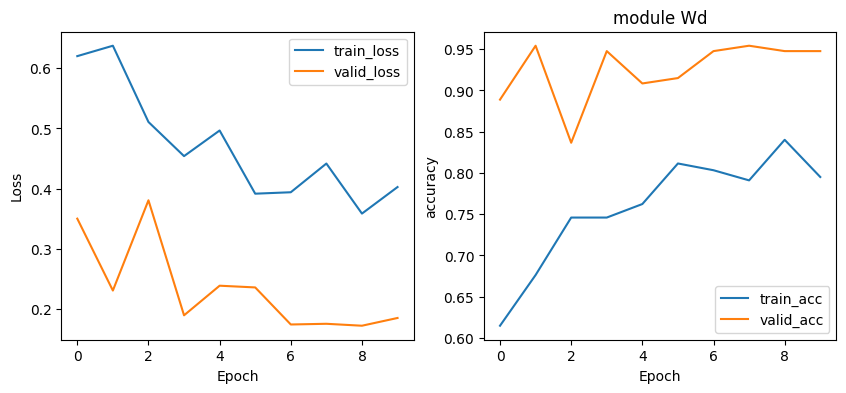

In [18]:
fig_6 = plt.figure() 
fig_6.set_size_inches(10, 4)
plt.subplots_adjust(wspace=0.2, hspace=0.35)
ax_6_1 = plt.subplot(1,2,1) 
ax_6_2 = plt.subplot(1,2,2)
ax_6_1.plot(range(num_epochs), train_loss_list_9, label = 'train_loss')
ax_6_1.legend()
ax_6_1.plot(range(num_epochs), valid_loss_list_9, label = 'valid_loss')
ax_6_1.legend()
ax_6_1.set_xlabel("Epoch")
ax_6_1.set_ylabel("Loss")
# ax_6_1.set_title("Performance of resnet18 model") 
ax_6_2.plot(range(num_epochs), train_accuracy_list_9, label = 'train_acc')
ax_6_2.legend()
ax_6_2.plot(range(num_epochs), valid_accuracy_list_9, label = 'valid_acc')
ax_6_2.legend()
ax_6_2.set_xlabel("Epoch")
ax_6_2.set_ylabel("accuracy")
# ax_6_2.set_title("Performance of resnet18 model")
plt.title("Performance of resnet18 model with a classification layer composed of two layers and hidden dim = 1024")
plt.show()

Quantization of resnet18 model

In [26]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    print("model: ", label, " \t", "Size (KB):", size / 1e3)
    os.remove("temp.p")
    return size




In [28]:
print_size_of_model(model_N1, "fp32")
quantized_model_N1 = torch.quantization.quantize_dynamic(model_N1, dtype=torch.qint8)
print_size_of_model(quantized_model_N1, "int8")

model:  fp32  	 Size (KB): 44780.42
model:  int8  	 Size (KB): 44778.17


44778170

Dynamic quantization only helps in reducing the model size for models that use Linear and LSTM modules. For the case of resnet18, the model consists of conv layers which do not have dynamic

In [25]:

test_loss_list_10 = []
test_accuracy_list_10 = []

def test_model (model, criterion):
    since = time.time()

    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataloaders["test"] :
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    test_loss = running_loss/dataset_sizes["test"]
    test_accuracy = running_corrects.double()/dataset_sizes["test"]
    test_loss_list_10.append(test_loss)
    test_accuracy_list_10.append(test_accuracy)

    print("test loss is %2f and test accuracy  is %2f" %(test_loss, test_accuracy ))

    return test_loss, test_accuracy
    
# Send the model to the GPU
quantized_model_N1 = quantized_model_N1.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(quantized_model_N1, criterion)

test loss is 0.121837 and test accuracy  is 0.950000


Quantization of resnet18 model with a set of two layers for classification and hidden dim = 256

In [29]:
print_size_of_model(model_N2, "fp32")
quantized_model_N2 = torch.quantization.quantize_dynamic(model_N2, dtype=torch.qint8)
print_size_of_model(quantized_model_N2, "int8")

model:  fp32  	 Size (KB): 45304.25
model:  int8  	 Size (KB): 44911.014


44911014

In [30]:
test_loss_list_11 = []
test_accuracy_list_11 = []

def test_model (model, criterion):
    since = time.time()

    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataloaders["test"] :
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    test_loss = running_loss/dataset_sizes["test"]
    test_accuracy = running_corrects.double()/dataset_sizes["test"]
    test_loss_list_11.append(test_loss)
    test_accuracy_list_11.append(test_accuracy)

    print("test loss is %2f and test accuracy  is %2f" %(test_loss, test_accuracy ))

    return test_loss, test_accuracy
    
# Send the model to the GPU
quantized_model_N2 = quantized_model_N2.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(quantized_model_N2, criterion)

test loss is 0.101985 and test accuracy  is 1.000000


Quantization of resnet18 model with a set of two layers for classification and hidden dim = 1024

In [31]:
print_size_of_model(model_N3, "fp32")
quantized_model_N3 = torch.quantization.quantize_dynamic(model_N3, dtype=torch.qint8)
print_size_of_model(quantized_model_N3, "int8")

model:  fp32  	 Size (KB): 46886.33
model:  int8  	 Size (KB): 45308.838


45308838

In [32]:
test_loss_list_12 = []
test_accuracy_list_12 = []

def test_model (model, criterion):
    since = time.time()

    running_loss = 0.0
    running_corrects = 0
    model.eval()
    for inputs, labels in dataloaders["test"] :
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    test_loss = running_loss/dataset_sizes["test"]
    test_accuracy = running_corrects.double()/dataset_sizes["test"]
    test_loss_list_12.append(test_loss)
    test_accuracy_list_12.append(test_accuracy)

    print("test loss is %2f and test accuracy  is %2f" %(test_loss, test_accuracy ))

    return test_loss, test_accuracy
    
# Send the model to the GPU
quantized_model_N3 = quantized_model_N3.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(quantized_model_N3, criterion)

test loss is 0.055903 and test accuracy  is 1.000000
